The Updated Guide to Image Classification - Fastai Part 2

In this guide, we'll cover how to obtain image data and use it to train a model.

## Obtaining Images
Sometime ago, Bing search API was used to obtain images.  However, the API will sunset in Auguest 2025.  Currently, there are some alternatives ways to obtaining images:

1.DuckDuckGo Image Search (Unofficial): It requires no signup nor API key.  As it is unofficial, the quality of images is not guaranteed and it may break should DuckDuckGo change their search engine.

```python
from duckduckgo_search import ddg_images

results = ddg_images("golden retriever", max_results=10)
for r in results:
    print(r["image"])
```

2. [SerpAPI](https://serpapi.com/), which is a Google/Bing/Yahoo wrapper.  It provides a free tier and pay if you need more.

3. [Unsplash API](https://unsplash.com/developers): It provvides access to high-quality, royalty-free images.  It requires an API key.  Free for small-scale use.

4. [Pexels](https://www.pexels.com/api/): It provides access to a vast library of free stock photos.  It requires an API key.  Free for small-scale use.

5. [Pixabay](https://pixabay.com/api/docs/): It provides access to a vast library of free stock photos and videos.  It requires an API key.  Free for small-scale use.

6. [Flickr](https://www.flickr.com/services/api/): It provides access to a vast library of free stock photos and videos.  It requires an API key.  Free for small-scale use.

You may choose whatever fits your needs based on image requirements and scale.  But we will use [Kaggle datasets](https://www.kaggle.com/datasets) for this guide.

## Downloading the Dataset

First we need to use Kaggle CLI to download the the standford dogs dataset into Notebooks directory.

```bash
# create/activate a property virtual environment and install kaggle-cli
pip install kaggle
# then you will need to obtain a kaggle.json file from your Kaggle account
mkdir -p ~/.kaggle
mv /path/to/your/Downloads/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d jessicali9530/stanford-dogs-dataset
```
This downloads a zip file into the Notebooks directory.  We need to unzip it and move the images into a new directory called `stanford-dogs-dataset`.

## Exploring the Dataset

This Stanford Dogs dataset contains 20580 images of dogs belonging to 120 breeds.  The dataset is split into training and testing sets, with 1000 images for each breed in the training set and 200 images for each breed in the testing set.  Let's take a look at its file structure:



In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
from pathlib import Path

data_path = Path('stanford-dogs-dataset/images/Images')
# each directory is a different breed of dog, such as "nn02107142-Doberman"
breeds = [d.name for d in data_path.iterdir() if d.is_dir()]
print(f"Number of breeds: {len(breeds)}")
print(f"Example breeds: {breeds[:5]}")

Number of breeds: 120
Example breeds: ['n02097658-silky_terrier', 'n02092002-Scottish_deerhound', 'n02099849-Chesapeake_Bay_retriever', 'n02091244-Ibizan_hound', 'n02095314-wire-haired_fox_terrier']


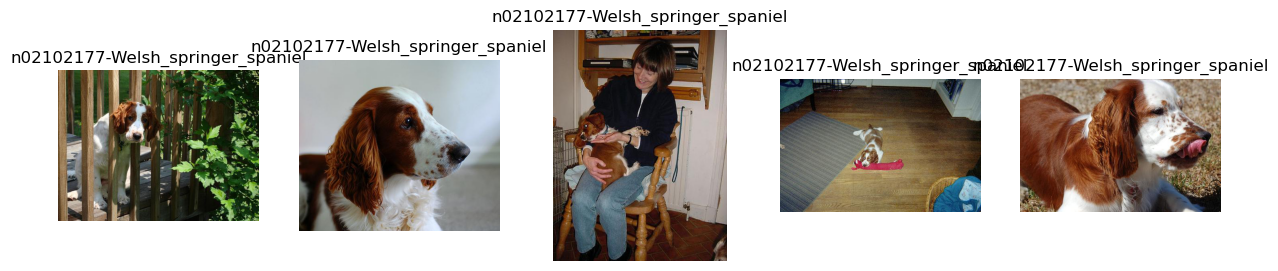

In [3]:
# Display 5 random images of a breed
import matplotlib.pyplot as plt
from PIL import Image
import random

sample_breed = random.choice(breeds)
sample_images = list((data_path/sample_breed).glob('*.jpg'))[:5]

fig, axs = plt.subplots(1, 5, figsize=(15,3))
for ax, img_path in zip(axs, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(sample_breed)
    ax.axis('off')
plt.show()

## Data Preparation with fastai

fastai makes it easy to load and preprocess image data. We’ll use the ImageDataLoaders.from_folder method, which expects images to be organized in subfolders by class.

A word about variable naming.  `item_tfms` is a fastai term for a transformation applied to each image (item).  IMHO, `tfms` is an unfortunate choice of variable name, by choosing 4 letters out of `transform` which is far from being intuitive.  I also have to think about which 4-letter to spell out every time I use it.  Just use item_transform!  It's a lot more descriptive and you won't get carpal tunnel from typing 5 extra letters.  But what's even more annoying is that the variable could be named much more to the point, such as item_resize.  Technically speaking, resizing is a form a transformation which changes the dimension of the image.  Fastai has made a decision to using `tfms` throughout its library for consistency, hence sacrificing specifity and clarity.  I'm not an advocate of this approach.  I'd rather have a variable name that is more descriptive and easier to understand.  But that's just me.

The batch_tfms parameter is used to apply transformations to the entire batch of images.  It's a good idea to apply the same transformations to the training and validation sets.  This ensures that the training and validation sets are transformed in the same way, which helps to prevent overfitting.  The function `aug_transforms` creates a standard set of data augmentation transforms, such as random flips, rotations, zooms, warps, and more. The mult=1.0 argument controls the strength of these augmentations (1.0 is the default strength).  This is what we call `data augmentation` in machine learning, especially in computer vision, to artificially increase the size and diversity of your training dataset by applying random transformations to your images.
Common augmentations include:
- Flipping images horizontally or vertically
- Rotating images by small angles
- Zooming in or out
- Changing brightness or contrast
- Cropping or warping

/opt/anaconda3/envs/ml_study/lib/python3.12/site-packages/torch/_tensor.py:1648: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  ret = func(*args, **kwargs)


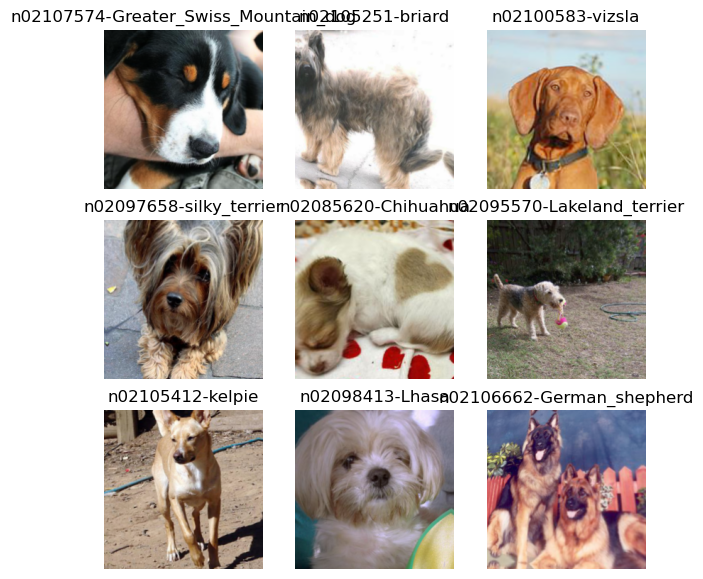

In [ ]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(
    data_path,
    valid_pct=0.2,        # 20% for validation
    seed=42,
    item_tfms=Resize(224), # Resize images to 224x224
    batch_tfms=aug_transforms(mult=1.0) # Data augmentation
)

dls.show_batch(max_n=9, figsize=(7,7))

### The Unfortunate Fallback

On my M1 Macbook Pro, running the above code will result in a known issue: [PyTorch Issue #141287](https://github.com/pytorch/pytorch/issues/141287).  This is due to the fact that the MPS backend is not yet supported by PyTorch.  As a temporary fix, we can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op.  WARNING: this will be slower than running natively on MPS.  This is why we have enabled MPS fallback at the very beginning of the notebook, before we imported any other libraries.

## Model Training
We will use a pre-trained ResNet34 model, which is a good starting point for image classification tasks.

The fine_tune method first fits the head of the model, then unfreezes and trains the entire model for a few epochs. You’ll see the training and validation accuracy after each epoch.

In [5]:
# check out part1 of this series for more explanation of the code
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/zlu/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.8MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.518806,0.669011,0.792517,03:30


epoch,train_loss,valid_loss,accuracy,time
0,1.063292,0.801603,0.754616,04:42
1,0.810561,0.618079,0.811710,04:45
2,0.516495,0.560497,0.824830,04:37


## Evaluation
Let’s evaluate the model’s performance in more detail and plot the confusion matrix.
1. ClassificationInterpretation.from_learner(learn): Creates a ClassificationInterpretation object from your trained fastai Learner (here, called learn).  It provides tools to help you analyze and understand model’s predictions.  It also collects the model’s predictions, the actual labels, and calculates which predictions were correct or incorrect.

2. interp.plot_confusion_matrix(figsize=(12,12), dpi=60): Plots a confusion matrix for your model’s predictions.  A confusion matrix is a table that shows how often your model predicted each class versus the actual class.  The rows represent the actual classes.  The columns represent the predicted classes.  The diagonal cells (top-left to bottom-right) show correct predictions.  Off-diagonal cells show misclassifications (where the model got it wrong).  The figsize and dpi arguments control the size and resolution of the plot.

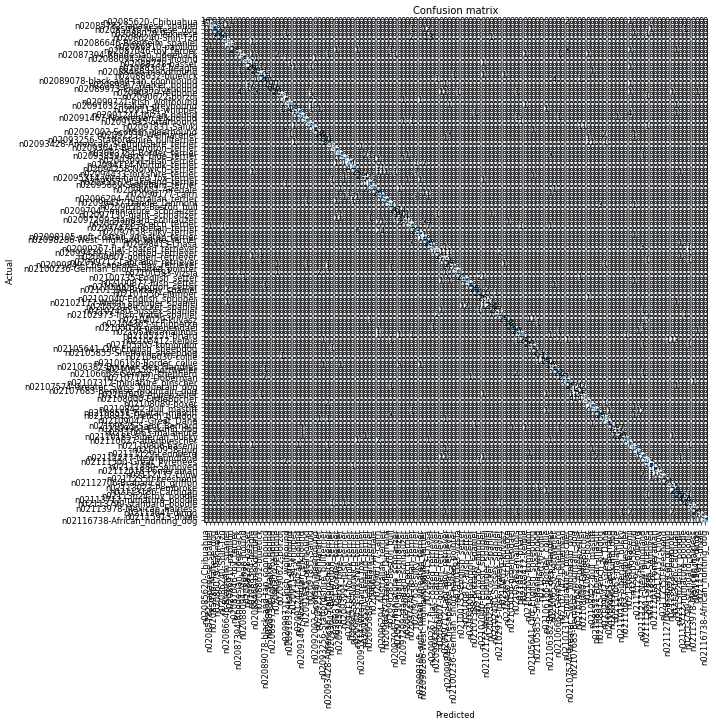

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
# It does make sense actually to show the confusion matrix as there are 120 dog breeds (classes).
# So later we will deal with this.
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
most_confused = interp.most_confused()[:5]
print(most_confused)

[('n02086240-Shih-Tzu', 'n02098413-Lhasa', np.int64(13)), ('n02110185-Siberian_husky', 'n02110063-malamute', np.int64(13)), ('n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', np.int64(11)), ('n02106030-collie', 'n02106166-Border_collie', np.int64(11)), ('n02091032-Italian_greyhound', 'n02091134-whippet', np.int64(9))]


In [26]:
# Flatten the pairs to get unique class names
confused_classes = set()
for a, b, _ in most_confused:
    confused_classes.add(a)
    confused_classes.add(b)
confused_classes = list(confused_classes)
print(confused_classes)

# Get the indices of these classes
class2idx = {v: k for k, v in enumerate(interp.vocab)}
idxs = [class2idx[c] for c in confused_classes]

['n02110063-malamute', 'n02093256-Staffordshire_bullterrier', 'n02091134-whippet', 'n02093428-American_Staffordshire_terrier', 'n02091032-Italian_greyhound', 'n02086240-Shih-Tzu', 'n02110185-Siberian_husky', 'n02106166-Border_collie', 'n02106030-collie', 'n02098413-Lhasa']


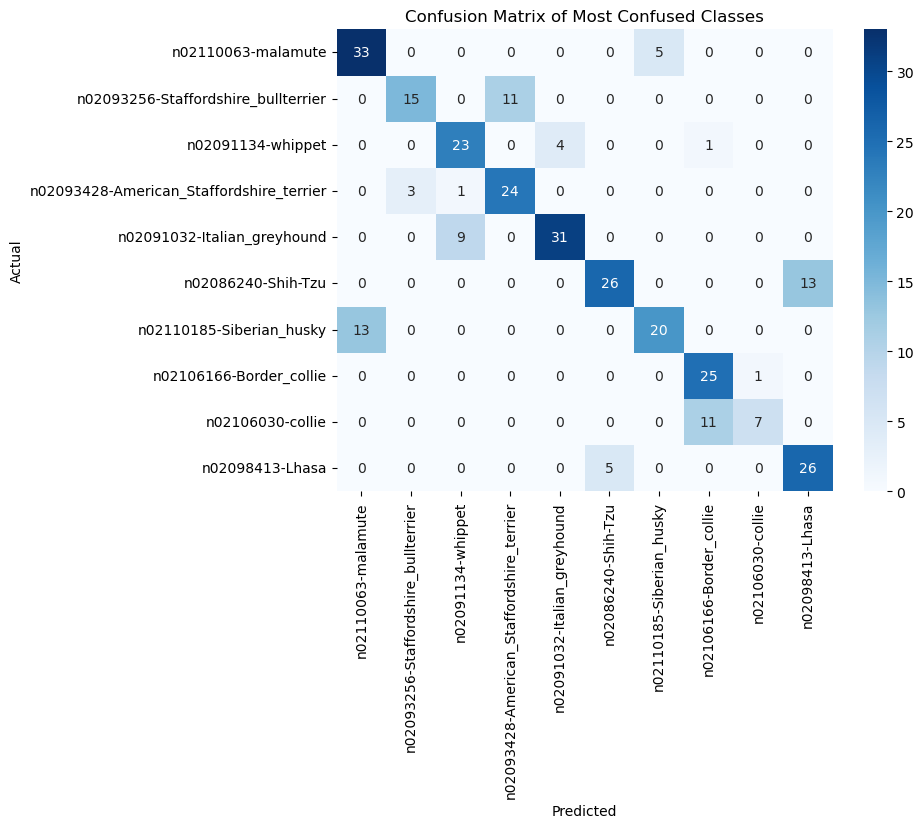

In [27]:
# Extract the sub-matrix of the most confused classes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm = interp.confusion_matrix()
sub_cm = cm[np.ix_(idxs, idxs)]

plt.figure(figsize=(8,6))
sns.heatmap(sub_cm, annot=True, fmt='d', 
            xticklabels=confused_classes, 
            yticklabels=confused_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Most Confused Classes')
plt.show()

### Reading the Confusion Matrix

It can be confusing to read the confusion matrix as its name implies.

**In a confusion matris**

Axes:

The rows represent the actual (true) dog breed labels.
The columns represent the predicted dog breed labels made by your model.

Cells:

Each cell shows the number of images of a particular actual breed (row) that were predicted as a particular breed (column).
The diagonal cells (top-left to bottom-right) show correct predictions (where actual = predicted).
Off-diagonal cells show misclassifications (where the model confused one breed for another).

**So the above confusion matrix shows:**

Most Confused Pairs:

The breeds shown here are the ones your model confuses the most, as selected from your dataset.
For example, "Siberian_husky" and "malamute" are often confused, which makes sense as they look similar.
"Shih-Tzu" and "Lhasa" are also confused, likely due to visual similarity.

Model Strengths and Weaknesses:

The model is generally good at distinguishing these breeds (high numbers on the diagonal).
However, for some pairs, the model struggles, which could be due to:
Similar appearance between breeds
Insufficient or ambiguous training data for those breeds

### Viewing top losses:

Here loss is a measure of how wrong the model’s prediction was for a particular image.  A higher loss means the model was more confident in an incorrect prediction, or was very uncertain.

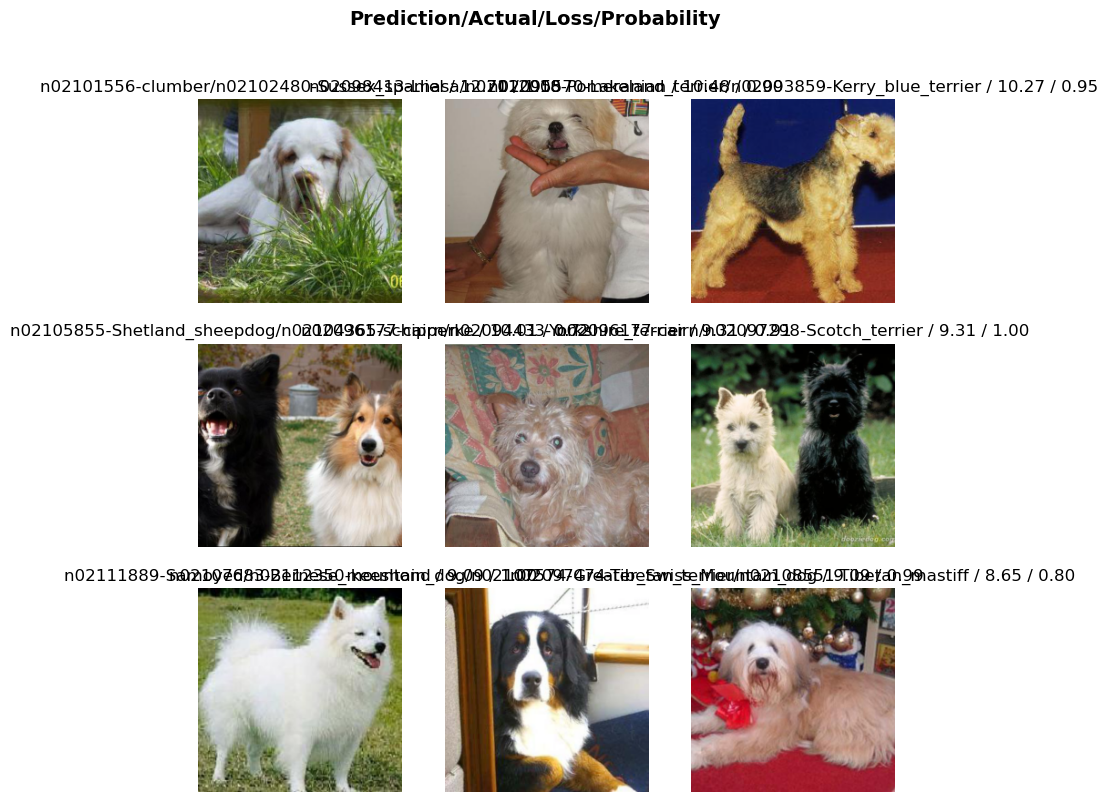

In [7]:
interp.plot_top_losses(9, nrows=3)

## Model Inference
To use the model on new images, simply call learn.predict:

In [9]:
img = PILImage.create('stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg')
pred_class, pred_idx, outputs = learn.predict(img)
print(f"Predicted: {pred_class}")

Predicted: n02085620-Chihuahua


## Model Export and Import
You can also export your trained model and reload it later:

In [18]:
learn.export('dog_breed_classifier.pkl')
# Important: Load the exported model after the model pkl is saved.
learn_inf = load_learner('dog_breed_classifier.pkl')

## Conclusion
In this post, we walked through building a dog breed classifier using the fastai library and the Stanford Dogs dataset. We explored the dataset, prepared the data, trained a state-of-the-art deep learning model, and evaluated its performance. With just a few lines of code, fastai enables rapid prototyping and high accuracy on challenging image classification tasks.